For this project, the bone fracture dataset linked below was used:
https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data

The dataset is quite large and I skipped uploading it into GitHub repo. 

To run the notebook, download and unzip the bone fracture data. Then place the folder **`dataset_bone_fracture`** containing **`test`**, **`train`**, and **`val`** folders into the directory of notebook. 

## Imports and Config

In [1]:
# Basic plotting libraries
import os # for file and directory manipulation
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600 # set to higher resolution of the figures
import seaborn as sns

# Libraries for image manipulation and visualization
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm # progress bar for loops
import cv2 # easy-to-use interface for working with image

# ML libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

## Exploratory Data Analysis

**Exploring Dataset**

The **`explore_dataset`** function loops through the dataset splits in their directories and inspects their structure and number of files per each split:

In [2]:
def explore_dataset(base_path):
    print(f"Exploring structure of: {base_path}")
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_path, split)
        for category in ['fractured', 'not_fractured']:
            category_path = os.path.join(split_path, category)
            total = len(os.listdir(category_path))
            print(f"{split}/{category} - {total} files")

explore_dataset('dataset_bone_fracture')

Exploring structure of: dataset_bone_fracture
train/fractured - 4603 files
train/not_fractured - 4640 files
val/fractured - 337 files
val/not_fractured - 492 files
test/fractured - 238 files
test/not_fractured - 268 files


**Showcase: Grid of Sample Images**

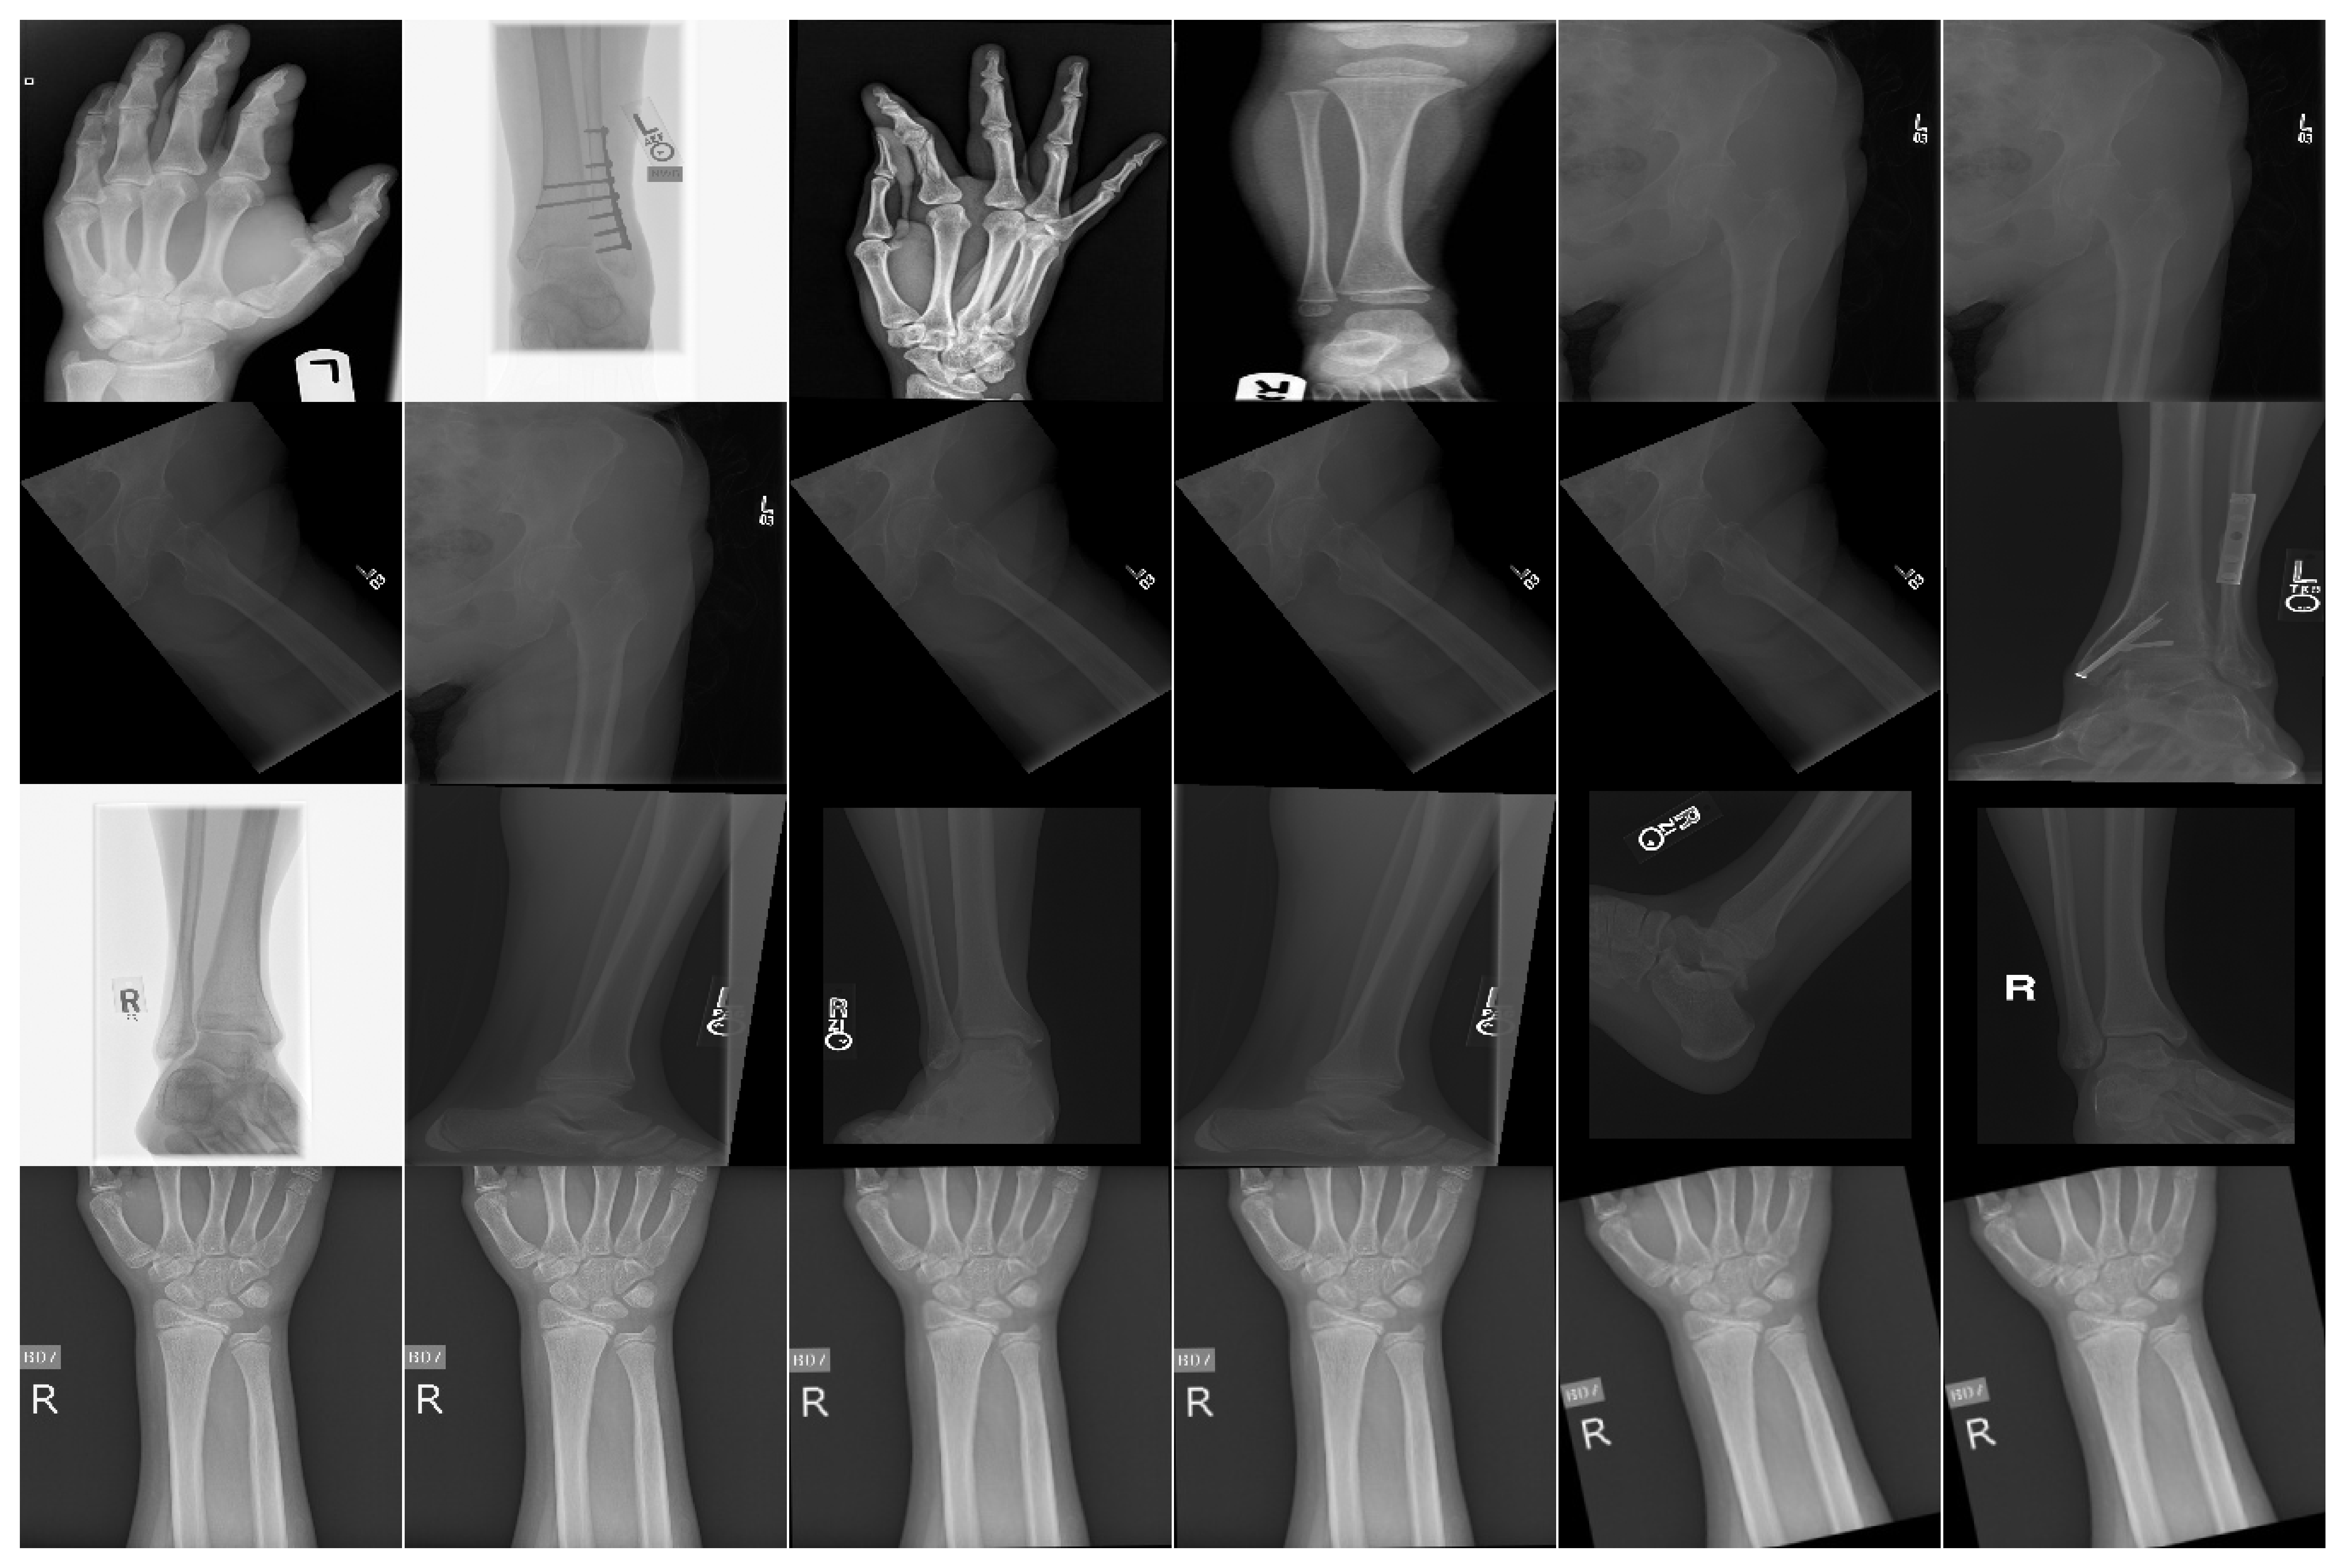

In [3]:
def show_image_grid_no_labels(base_path, rows=4, cols=6):
    labels = ['fractured', 'not_fractured']
    img_paths = []

    # Collect image paths from both categories (even split)
    for label in labels:
        folder = os.path.join(base_path, label)
        files = os.listdir(folder)[:(rows * cols) // 2]
        img_paths.extend([(os.path.join(folder, file), label) for file in files])

    fig = plt.figure(figsize=(cols * 2.5, rows * 2.5))
    idx = 0
    for i in range(rows):
        for j in range(cols):
            if idx >= len(img_paths):
                break
            path, _ = img_paths[idx]
            try:
                img = Image.open(path)
                ax = plt.subplot(rows, cols, idx + 1)
                ax.imshow(img, cmap='gray')
                ax.axis('off')
            except Exception as e:
                print(f"Could not open {path}: {e}")
            idx += 1

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# Show 4x6 grid from training set
show_image_grid_no_labels("dataset_bone_fracture/train", rows=4, cols=6)

## Clean Dataset

**Remove corrupted images:**

In [4]:
def clean_images(base_path, image_size=(224, 224)):
    def is_image_valid(path):
        try:
            img = Image.open(path)
            img.verify()
            return True
        except (UnidentifiedImageError, OSError):
            return False

    for split in ['train', 'val', 'test']:
        for category in ['fractured', 'not_fractured']:
            folder_path = os.path.join(base_path, split, category)
            for fname in tqdm(os.listdir(folder_path), desc=f"Cleaning {split}/{category}"):
                path = os.path.join(folder_path, fname)
                if not is_image_valid(path):
                    print(f"Removing corrupted: {path}")
                    os.remove(path)
                else:
                    try:
                        img = cv2.imread(path)
                        img = cv2.resize(img, image_size)
                        cv2.imwrite(path, img)
                    except Exception as e:
                        print(f"Error resizing {path}: {e}")
                        os.remove(path)

clean_images("dataset_bone_fracture")

Cleaning test/not_fractured: 100%|██████████| 268/268 [00:00<00:00, 276.95it/s]


## Visualize Image Distribution

**Image Distribution across Splits:**

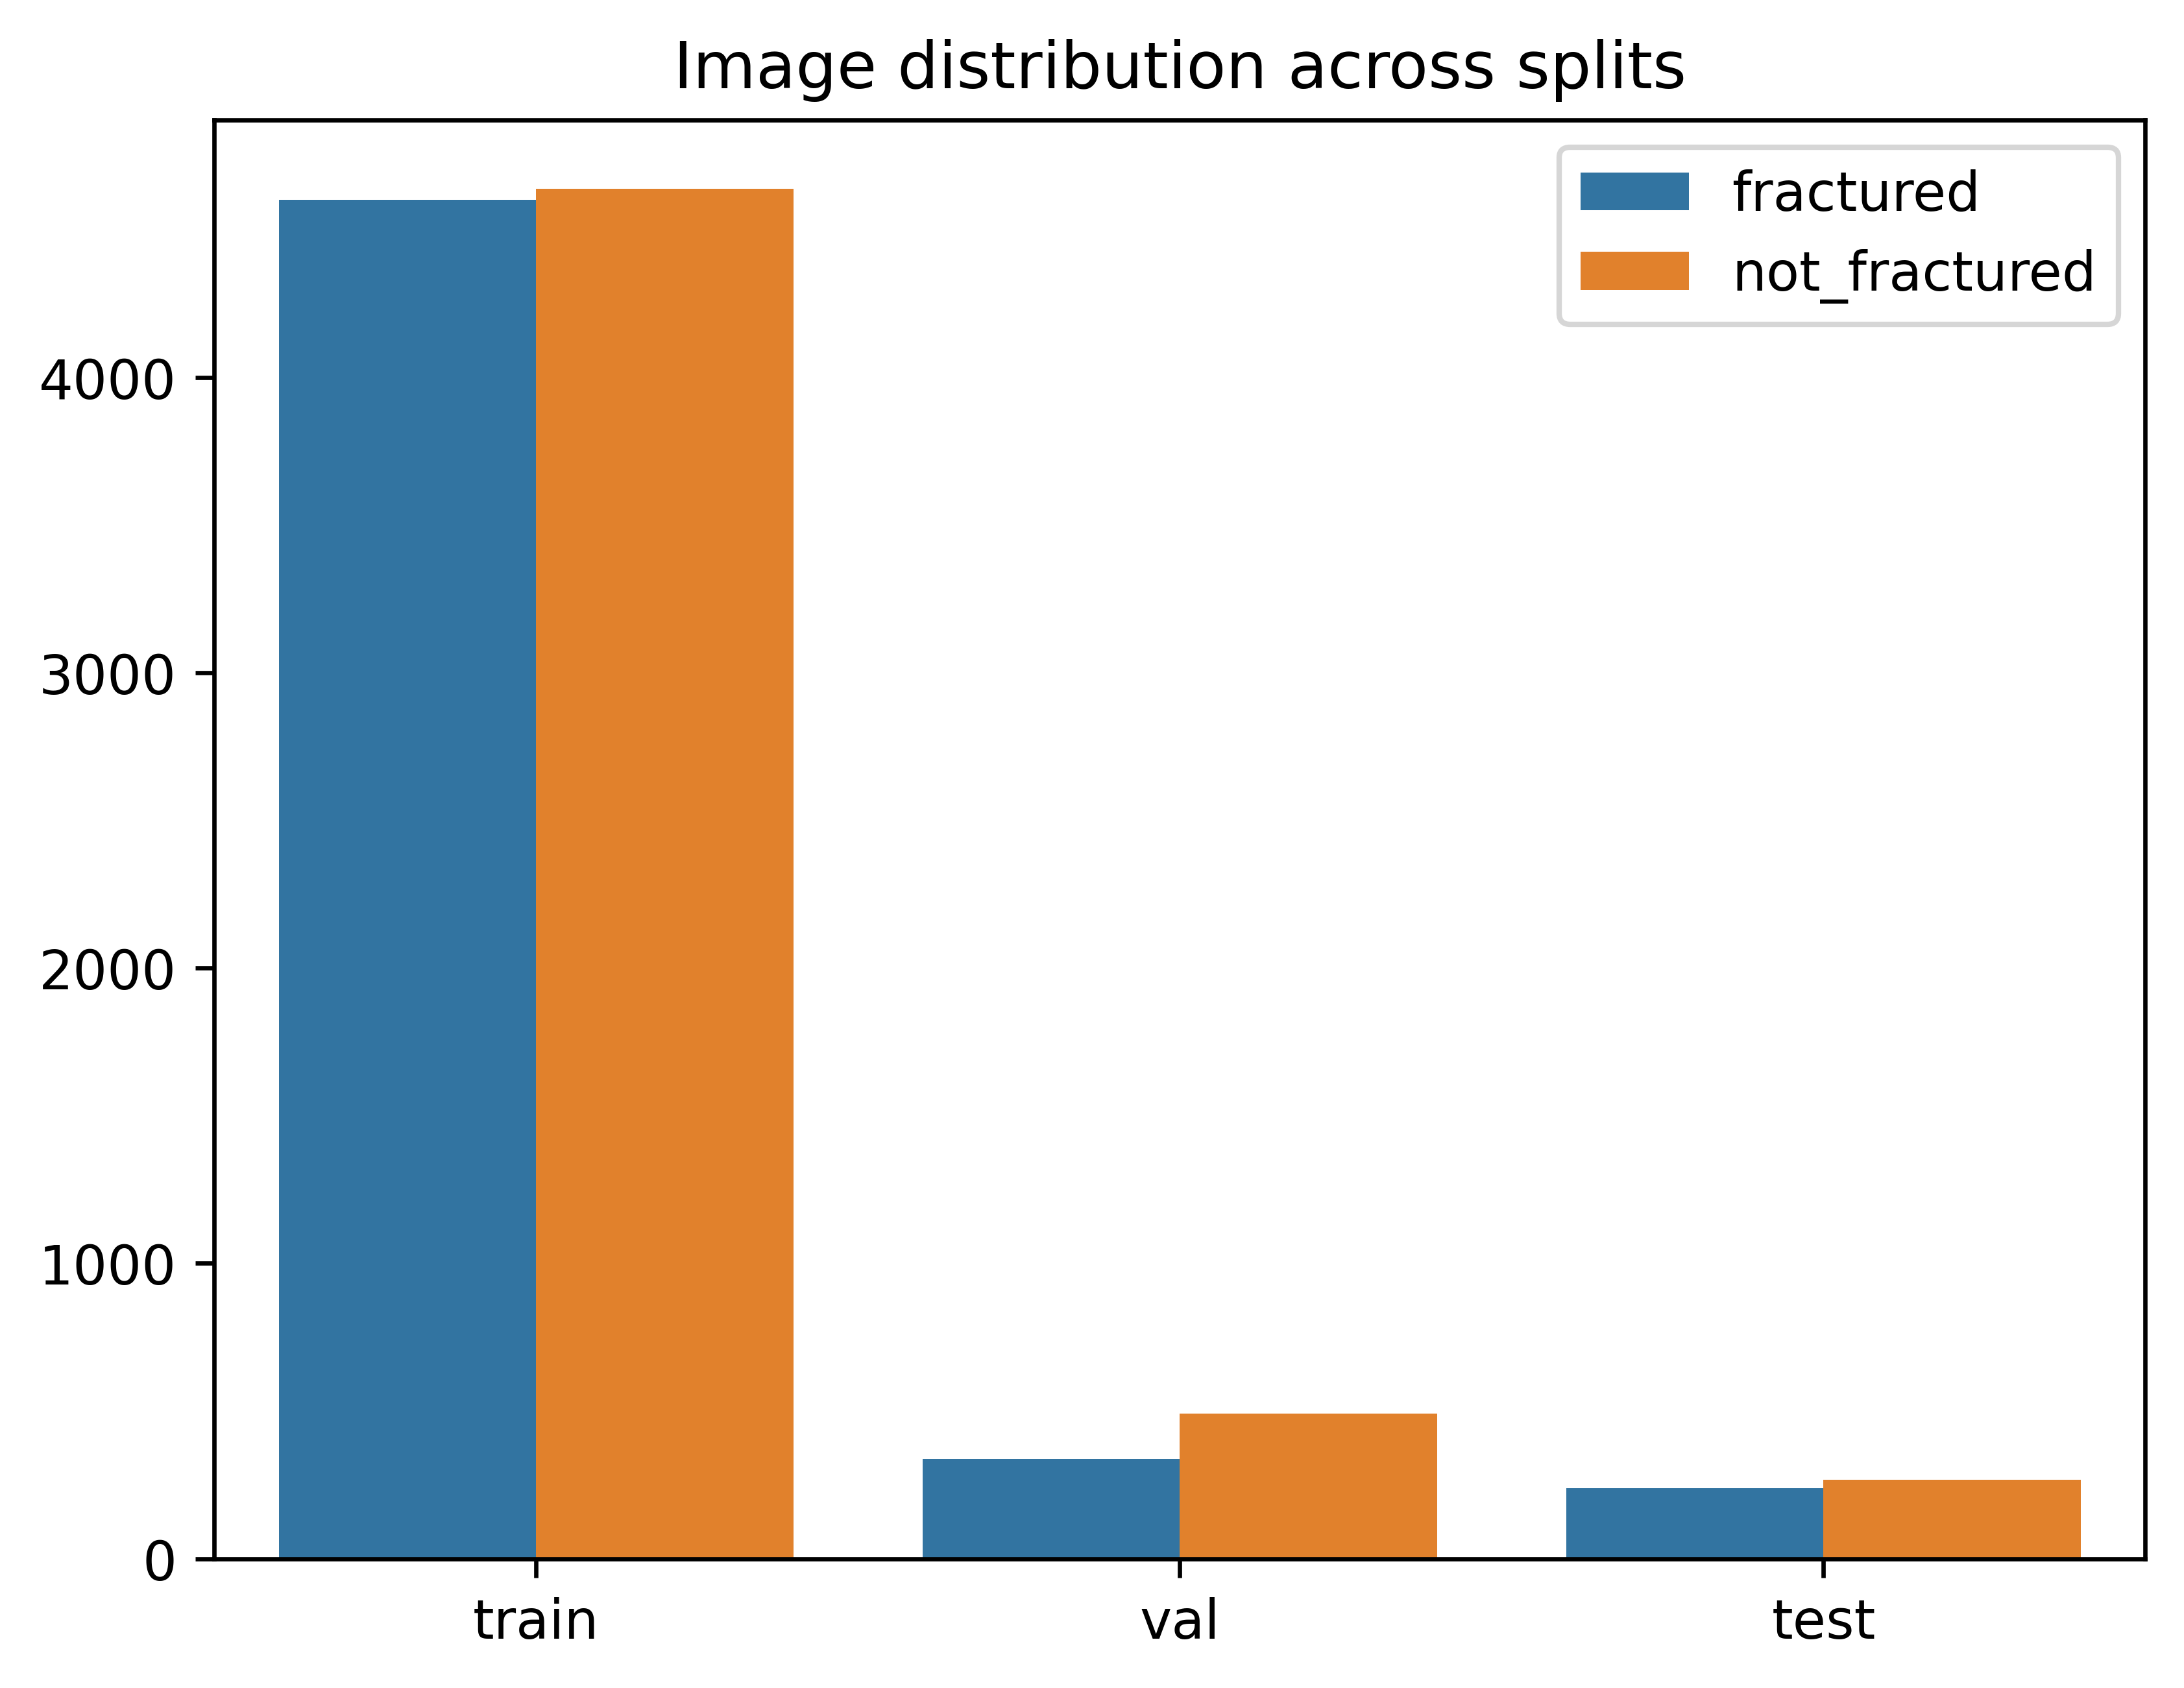

In [5]:
def plot_distribution(base_path):
    data = {'split': [], 'category': [], 'count': []}
    for split in ['train', 'val', 'test']:
        for category in ['fractured', 'not_fractured']:
            path = os.path.join(base_path, split, category)
            data['split'].append(split)
            data['category'].append(category)
            data['count'].append(len(os.listdir(path)))
    
    sns.barplot(x=data['split'], y=data['count'], hue=data['category'])
    plt.title("Image distribution across splits")

    # Save the plot (optional)
    plt.savefig("image_distribution.png", dpi=600, bbox_inches='tight')

    plt.show()

plot_distribution("dataset_bone_fracture")

## Preprocessing and Augmentation

**Preprocessing and Augmentation**
- Constants: **`IMG_SIZE=(224,224)`**, **`BATCH_SIZE=32`**
- Random Transformations: rotation, shift, zoom, flips
- Normalization: rescales pixel values to **`[0,1]`** for better Neural Network performance
- **`ImageDataGenerator`** is applied for training, validation, and testing a binary classification task
- **`shuffle=False`** for test data ensures prediction
- Class labels are inferred from subfolder names (frac, non-frac)

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory("dataset_bone_fracture/train", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val_data = val_test_gen.flow_from_directory("dataset_bone_fracture/val", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_data = val_test_gen.flow_from_directory("dataset_bone_fracture/test", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

Found 9243 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


## Build Model

- Architecture: sequential
- Convolutional Layers: 32 filters, **`ReLU`** activation, **`3*3`** Kernel size, and **`224*224*3`** input shape 
- Pooling Layers: **`MaxPooling(2,2)`** downsamples feature maps
- Flatenning: to create 1D dense layers
- **`Dropout(0.5)`** drops 50% of neurons during training
- Dense sets up fully connected layers
- Final Layer: 1 neuron (binary classification) and sigmoid activation

In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dropout (Dropout)           (None, 186624)          

## Train the Model

The **training history** generated by the model will be used to plot **Accuracy and Loss vs. Epoch**, as well as to generate the **Confusion Matrix and Classification Report**.

In [8]:
history = model.fit(train_data, validation_data=val_data, epochs=10, steps_per_epoch=len(train_data), validation_steps=len(val_data))

Epoch 1/10


289/289 [==============================] - 580s 2s/step - loss: 0.6220 - accuracy: 0.6535 - val_loss: 0.6733 - val_accuracy: 0.6972
Epoch 2/10
289/289 [==============================] - 402s 1s/step - loss: 0.4597 - accuracy: 0.7883 - val_loss: 0.4122 - val_accuracy: 0.8492
Epoch 3/10
289/289 [==============================] - 409s 1s/step - loss: 0.3659 - accuracy: 0.8393 - val_loss: 0.3522 - val_accuracy: 0.8625
Epoch 4/10
289/289 [==============================] - 414s 1s/step - loss: 0.3018 - accuracy: 0.8777 - val_loss: 0.2692 - val_accuracy: 0.9059
Epoch 5/10
289/289 [==============================] - 402s 1s/step - loss: 0.2562 - accuracy: 0.8988 - val_loss: 0.2718 - val_accuracy: 0.9107
Epoch 6/10
289/289 [==============================] - 423s 1s/step - loss: 0.2273 - accuracy: 0.9112 - val_loss: 0.2804 - val_accuracy: 0.9119
Epoch 7/10
289/289 [==============================] - 417s 1s/step - loss: 0.2089 - accuracy: 0.9220 - val_loss: 0.2770 - val_accuracy: 0.91

Optional: save history file

In [9]:
# Save history to a JSON file
"""
import json
history_path = "training_history.json"
with open(history_path, 'w') as f:
    json.dump(history.history, f)

print(f"Training history saved to {history_path}")
"""

'\nimport json\nhistory_path = "training_history.json"\nwith open(history_path, \'w\') as f:\n    json.dump(history.history, f)\n\nprint(f"Training history saved to {history_path}")\n'

## Accuracy and Loss vs. Epoch

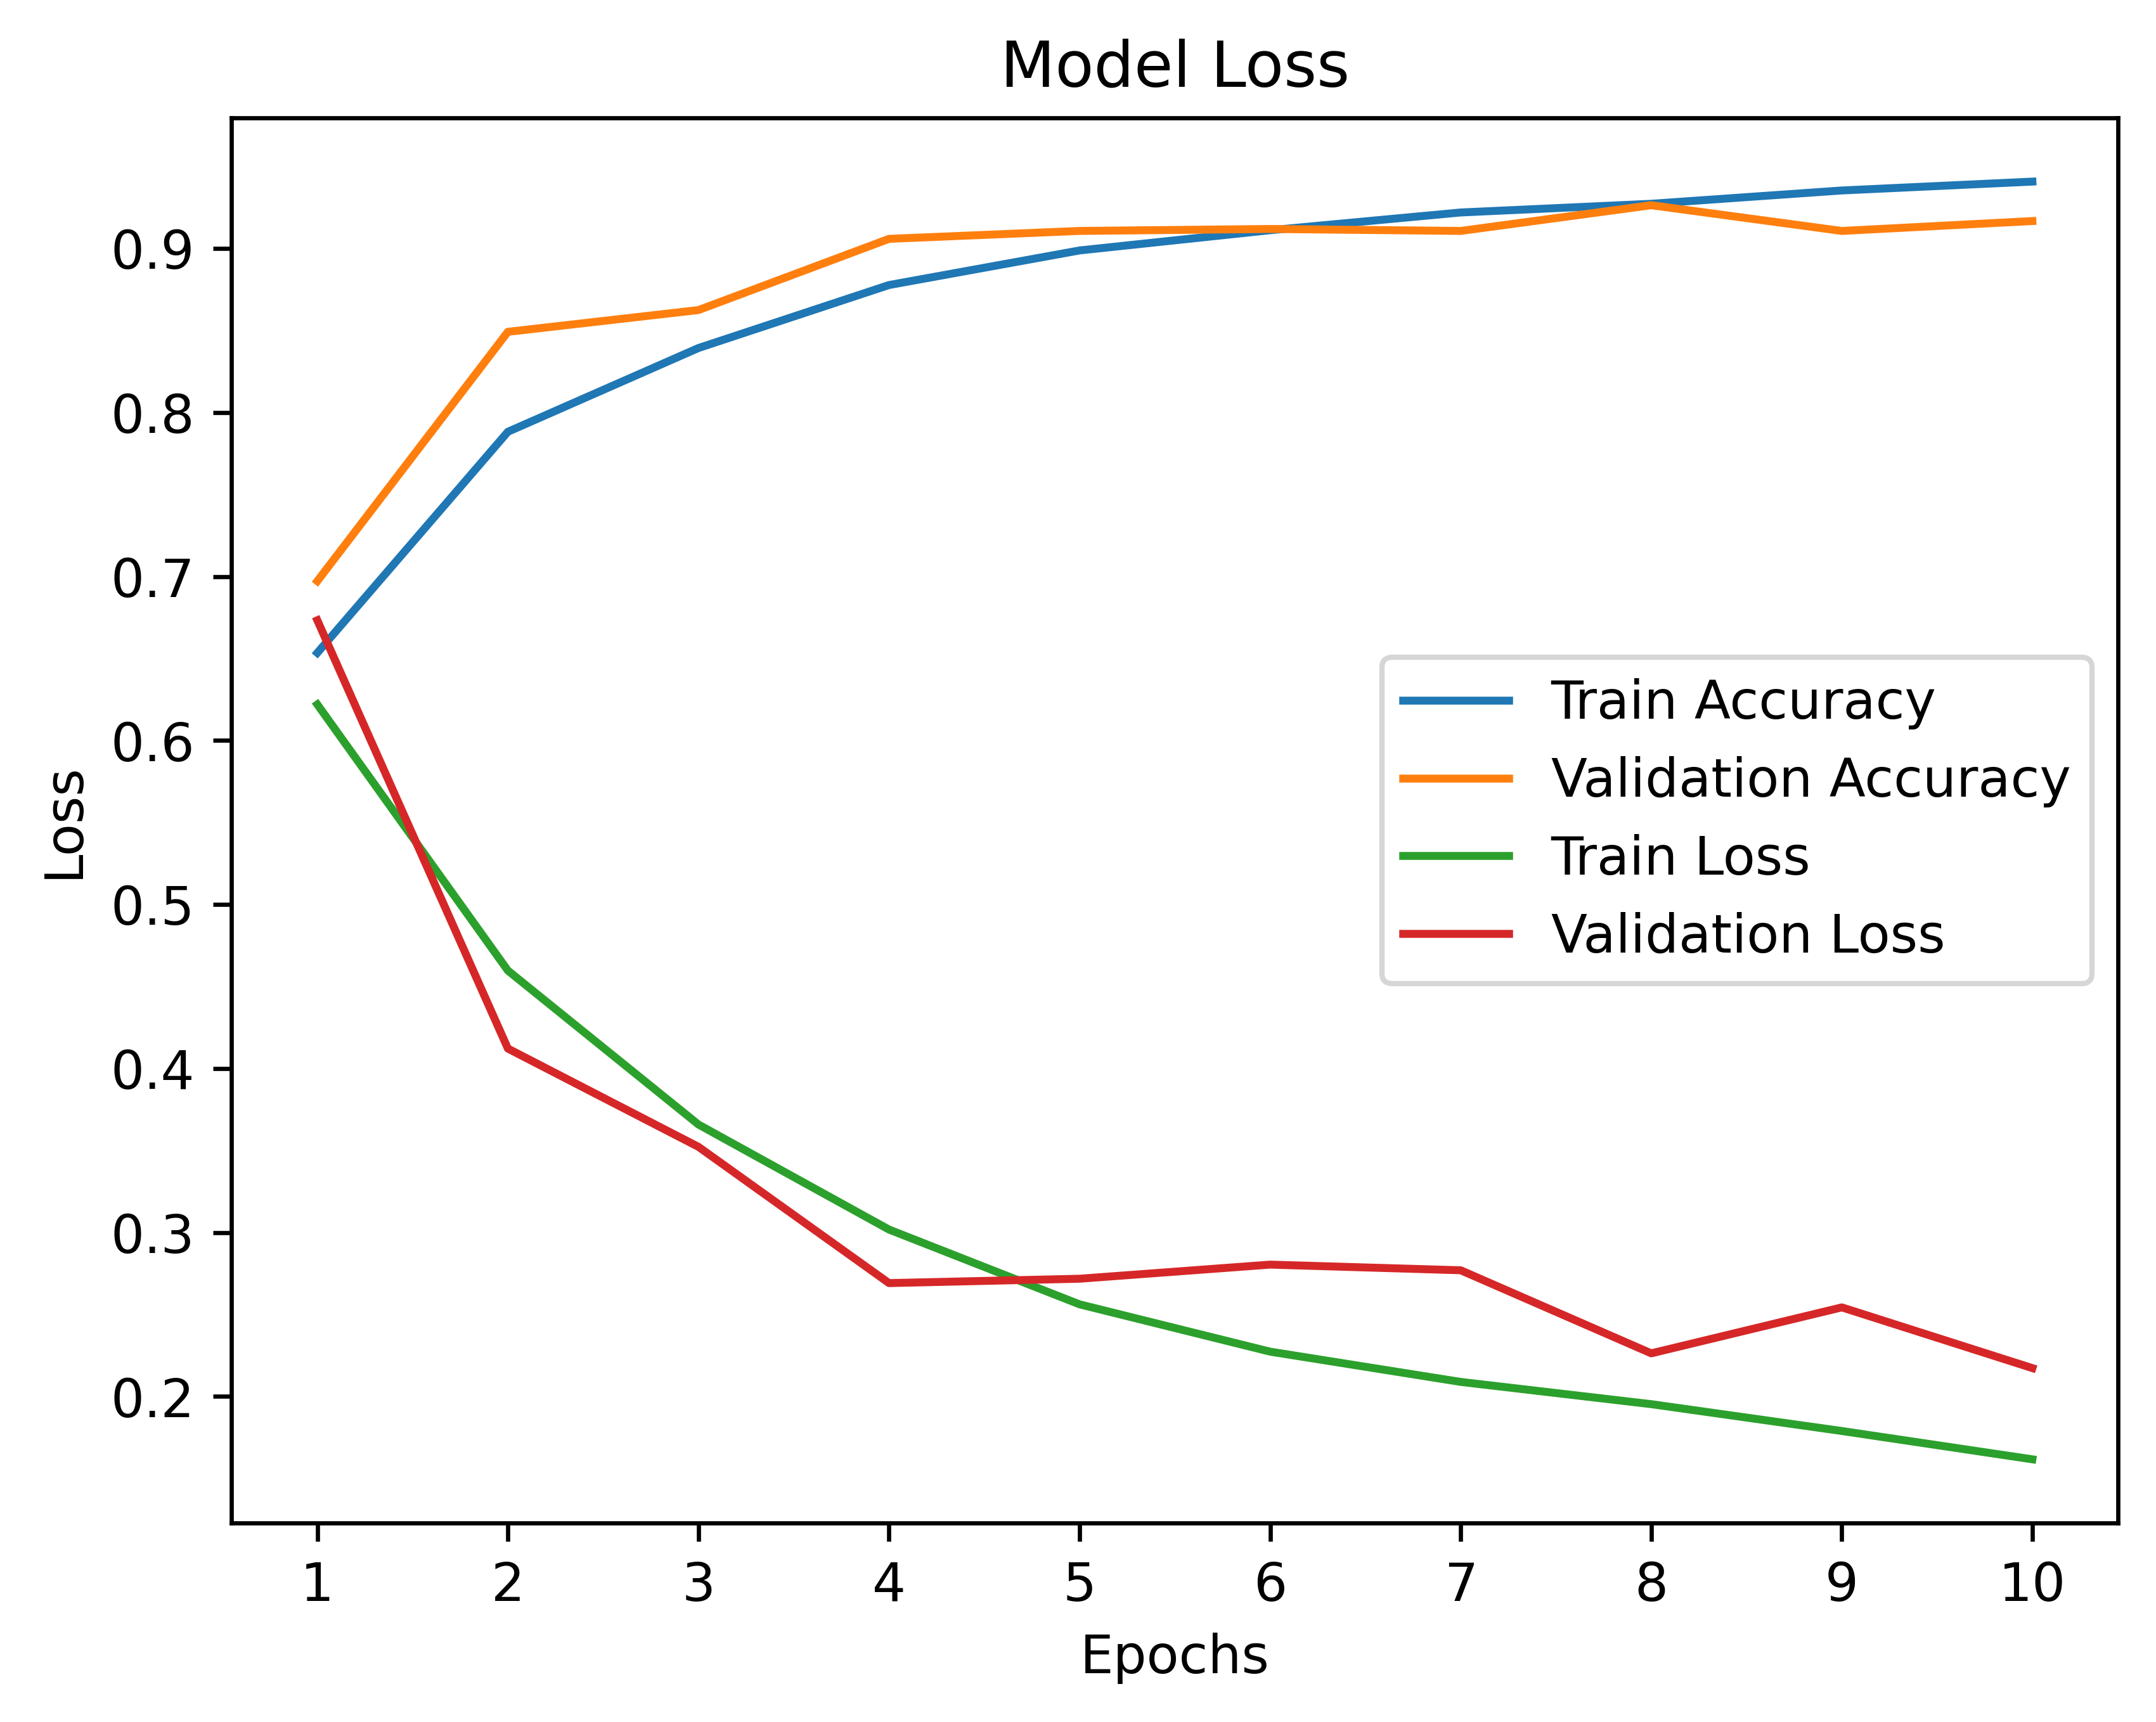

In [ ]:
def plot_training_history(history):
    
    epochs = range(1, len(history.history['accuracy']) + 1)  # Epochs start at 1
    
    # Plot Accuracy
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)  # Ensure x-axis ticks match epochs (1, 2, ..., 10)
    plt.legend()

    # Plot Loss
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)  # Ensure x-axis ticks match epochs (1, 2, ..., 10)
    plt.legend()

    # Save the plot (optional)
    plt.savefig("training_history_600dpi.png", dpi=600, bbox_inches='tight')
    
    plt.show()

# Example usage
plot_training_history(history)

## Confusion Matrix and Classification Report

16/16 [==============================] - 10s 617ms/step - loss: 0.1908 - accuracy: 0.9269
Test Accuracy: 92.69%
16/16 [==============================] - 4s 230ms/step
               precision    recall  f1-score   support

not_fractured       0.93      0.92      0.92       238
    fractured       0.93      0.94      0.93       268

     accuracy                           0.93       506
    macro avg       0.93      0.93      0.93       506
 weighted avg       0.93      0.93      0.93       506



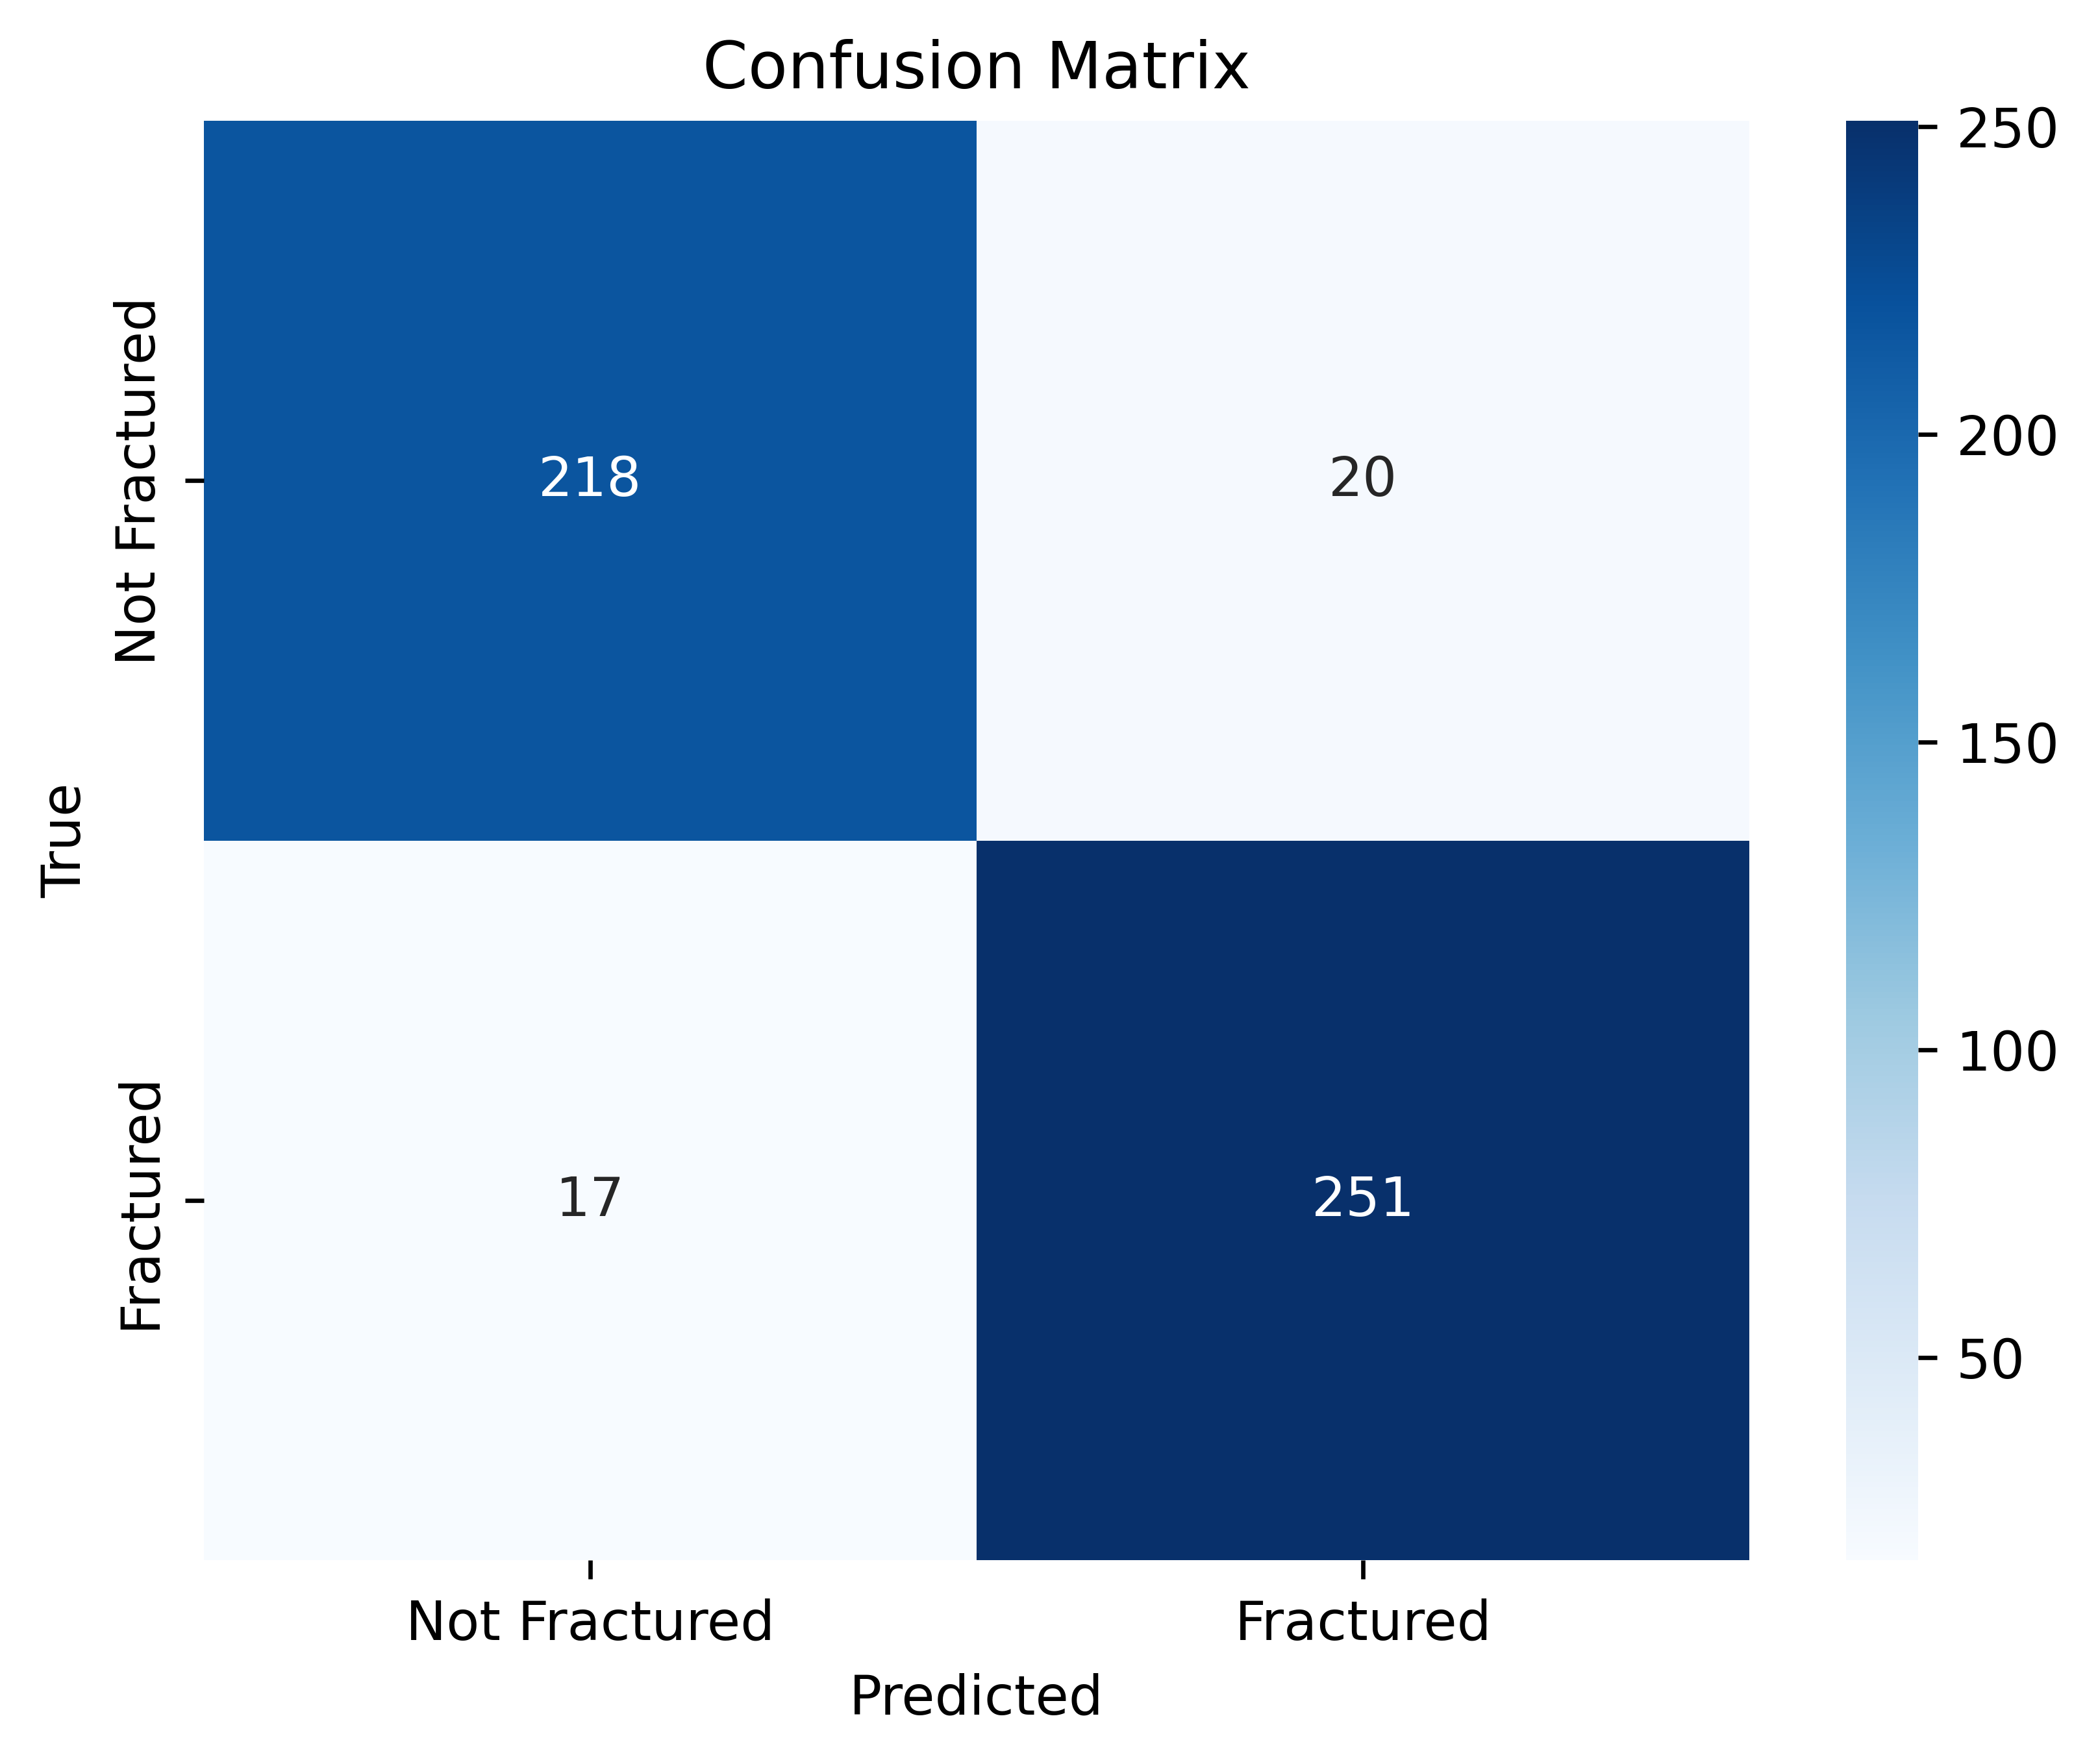

<Figure size 3840x2880 with 0 Axes>

In [11]:
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc*100:.2f}%")

# Confusion matrix and classification report
y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype("int32")

print(classification_report(y_true, y_pred, target_names=['not_fractured', 'fractured']))

conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(
    conf_mat, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=['Not Fractured', 'Fractured'], 
    yticklabels=['Not Fractured', 'Fractured']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Save the high-resolution plot (optional)
plt.savefig("confusion_matrix_600dpi.png", dpi=600, bbox_inches='tight')

plt.show()

Optional: read history file

In [12]:
# Read json file
"""
with open('training_history.json', 'r') as file:
    data = json.load(file)

print(data)
"""

"\nwith open('training_history.json', 'r') as file:\n    data = json.load(file)\n\nprint(data)\n"